# Example: MGLUR Example

In this example, we show using rxd to handle the kinetics of a mGLUR. In NEURON 7.7, we still need a brief MOD file to detect the synaptic event. 

## The Python code


In [1]:
!nrnivmodl

/usr/bin/xcrun
/Users/amygdk/Desktop/Yale/2022/lab/nrn/docs/rxd-tutorials
Mod files: "./mGluRRxD.mod" "./mglur.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.dylib
Successfully created x86_64/special


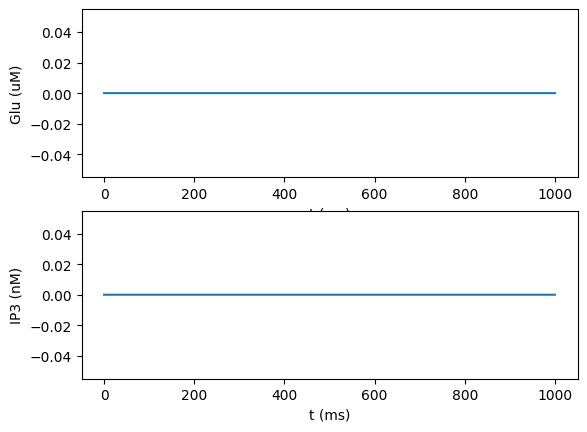

In [2]:
from neuron import h, rxd
from matplotlib import pyplot

h.load_file("stdrun.hoc")

# Paramters from https://SenseLab.med.yale.edu/ModelDB/ShowModel.cshtml?model=185858&file=/CaHDemo/mglur.mod#tabs-2
# species concentrations are in uM like the mod file rather than the standard mM

initmGluR = 0.3e-3  # Bhalla & Iyenger Science  1999
K1 = 0.28  # forward binding rate to receptor from Bhalla et al
K2 = 0.016  # backward (unbinding) rate of receptor from Bhalla et al
K_PLC = 5  # total concentration of PLC
K_PIP2 = 160  # total concentration of PIP2
K_G = 25  #
# kplc and Vmax describe aPLC catalyzing IP3 production from PIP2
kfplc = 0.83
kbplc = 0.68  # 0.1/ms in the paper; added to Vmax1=0.58/ms in the paper
Vmax1 = 0.58
# D5 and D6 describe Glu_mGluR catalyzing G_alpha production, Km2=(D6f+D5B)/D5f
D5f = 15
D5b = 7.2
D6f = 1.8
# G2 describe aG binding to PLC
G2f = 100
G2b = 100
# degradation of aG (D7f) and IP3 (G9f)
D7f = 9
degGluRate = 1.0  # should lookup value

# Spine Head
head = h.Section(name="head")
head.nseg = 1
head_L = 0.8  # um
head_d = 0.8  # um
h.pt3dadd(0, 0, 0, head_d, sec=head)
h.pt3dadd(0, 0, head_L, head_d, sec=head)
glu_per_spike = 1000  # number of molecules (arbitrarily choice for this example)

# RxD
spine_head = rxd.Region([head], nrn_region="i")

Glu = rxd.Species(spine_head, name="Glu", initial=0)
mGluR = rxd.Species(spine_head, name="mGluR", initial=initmGluR)
Glu_mGluR = rxd.Species(spine_head, name="Glu_mGluR", initial=0)
react1 = rxd.Reaction(Glu + mGluR, Glu_mGluR, K1, K2)


degGlu = rxd.Species(spine_head, name="degGlu", initial=0)
react2 = rxd.Reaction(Glu, degGlu, degGluRate)

G = rxd.Species(spine_head, name="G", initial=K_G)
GG_mGluR = rxd.Species(spine_head, name="GG_mGluR", initial=0)
react3 = rxd.Reaction(Glu_mGluR + G, GG_mGluR, D5f, D5b)

aG = rxd.Species(spine_head, name="aG", initial=0)
react4 = rxd.Reaction(GG_mGluR, aG + mGluR, D6f)
react5 = rxd.Reaction(aG, G, D7f)

PLC = rxd.Species(spine_head, name="PLC", initial=K_PLC)
aPLC_aG = rxd.Species(spine_head, name="aPLC_aG", initial=0)
react6 = rxd.Reaction(aG + PLC, aPLC_aG, G2f, G2b)

PIP2 = rxd.Species(spine_head, name="PIP2", initial=K_PIP2)
aPLC_PIP2 = rxd.Species(spine_head, name="aPLC_PIP2", initial=0)

react7 = rxd.Reaction(aPLC_aG + PIP2, aPLC_PIP2, kfplc, kbplc)


# ip3 degradation has been omitted in this example

# Add the synapse
syn = h.mGLUR(head(0.5))


# Noisy stimulation
h.Random(6324)
stim = h.NetStim()
stim.number = 100
stim.start = 0
stim.noise = 1
ncstim = h.NetCon(stim, syn)
ncstim.delay = 1
ncstim.weight[0] = glu_per_spike / (Glu.nodes[0].volume)  # number per um^3

ip3 = rxd.Species(spine_head, name="ip3", d=1.415, initial=0)
react8 = rxd.Reaction(aPLC_PIP2, ip3, Vmax1)


# Record
tvec = h.Vector()
tvec.record(h._ref_t)
Glu_vec = h.Vector()
Glu_vec.record(head(0.5)._ref_Glui)
ip3_vec = h.Vector()
ip3_vec.record(head(0.5)._ref_ip3i)


# Run simulation
h.finitialize()
h.continuerun(1000)

# Plot the result
pyplot.subplot(2, 1, 1)
pyplot.plot(tvec, Glu_vec)
pyplot.xlabel("t (ms)")
pyplot.ylabel("Glu (uM)")

pyplot.subplot(2, 1, 2)
pyplot.plot(tvec, ip3_vec.mul(1e3))
pyplot.xlabel("t (ms)")
pyplot.ylabel("IP3 (nM)")
pyplot.show()

## The synaptic event detection code

    NEURON {
  
    POINT_PROCESS mGLURRxD
    POINTER G
  
    }

    UNITS

    {

    CON = (1/micrometer3) (millimole/m3)  : count/volume to uM
    
    }

    ASSIGNED

    {

    G
    
    }

    NET_RECEIVE (weight)  {

    G = G + weight * CON
  
    }

### Output from revised mod file

![Alt text](synaptic_event.png)